# Property Inspection Report Analyzer - Streamlined RAG System

## Data Architecture:
- **Knowledge Base**: `data/my-report/Rental.PDF` → RAG system
- **Evaluation Dataset**: `data/inspection-reports/*.pdf` → RAGAS synthetic generation

**Target Use Case**: First-time home buyers needing prioritized repair recommendations with cost estimates.


In [169]:
import os
import getpass
from uuid import uuid4
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set up LangSmith tracing 
os.environ["LANGCHAIN_TRACING_V2"] = "true" 
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com/"
os.environ["LANGSMITH_PROJECT"] = f"Inspection-RAG-{uuid4().hex[0:8]}"

# Setup API keys 
if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

if not os.getenv("COHERE_API_KEY"):
    os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key: ")    

if not os.getenv("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key: ")

if not os.getenv("REPAIR_API_KEY"):
    repair_key = getpass.getpass("Repair API Key (or press Enter for demo): ")
    os.environ["REPAIR_API_KEY"] = repair_key if repair_key.strip() else "demo-key-2024"

if not os.getenv("LANGSMITH_API_KEY"):
    langsmith_key = getpass.getpass("LangSmith API Key (optional): ")
    if langsmith_key.strip():
        os.environ["LANGSMITH_API_KEY"] = langsmith_key
    else:
        os.environ["LANGCHAIN_TRACING_V2"] = "false"

print(f"LangSmith Project: {os.environ['LANGSMITH_PROJECT']}")



LangSmith Project: Inspection-RAG-98e16d98


In [170]:
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load the actual inspection report for RAG (following ref patterns)
inspection_path = "data/my-report/"
inspection_loader = DirectoryLoader(inspection_path, glob="*.pdf", loader_cls=PyMuPDFLoader)
inspection_docs = inspection_loader.load()

print(f"📄 Loaded inspection report: {len(inspection_docs)} documents")

# Load evaluation dataset documents for RAGAS (following ref patterns)
eval_path = "data/inspection-reports/"
eval_loader = DirectoryLoader(eval_path, glob="*.pdf", loader_cls=PyMuPDFLoader)
eval_docs = eval_loader.load()

print(f"📚 Loaded evaluation dataset: {len(eval_docs)} documents")

# Text splitting (following ref patterns)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

# Split documents
split_inspection_docs = text_splitter.split_documents(inspection_docs)
split_eval_docs = text_splitter.split_documents(eval_docs)

print(f"📝 Split inspection docs: {len(split_inspection_docs)} chunks")
print(f"📝 Split evaluation docs: {len(split_eval_docs)} chunks")


📄 Loaded inspection report: 36 documents
📚 Loaded evaluation dataset: 211 documents
📝 Split inspection docs: 94 chunks
📝 Split evaluation docs: 459 chunks


In [171]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# Core components (following ref patterns)
llm = ChatOpenAI(model="gpt-4o", temperature=0.1)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Setup vector store (following ref patterns)
client = QdrantClient(":memory:")
sample_embedding = embeddings.embed_query("test")
embedding_dim = len(sample_embedding)

client.create_collection(
    collection_name="inspection_knowledge",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="inspection_knowledge", 
    embedding=embeddings,
)

# Add inspection documents to vector store
_ = vector_store.add_documents(documents=split_inspection_docs)

# Create retriever (following ref patterns)
baseline_retriever = vector_store.as_retriever(search_kwargs={"k": 5})

print("✅ Vector store ready")


✅ Vector store ready


In [172]:
# RAG Chain 
RAG_TEMPLATE = """
You are an expert property inspection analyst helping first-time home buyers in Southern California understand their inspection report.

Your role is to analyze ONLY what the inspector actually found and documented in this specific inspection report.

INSTRUCTIONS:
- Use the tools provided to you to help answer the question.
- Base all responses strictly on the inspector's actual findings in the provided context or the tools provided to you.
- Focus on specific issues, defects, or concerns the inspector identified
- Ignore boilerplate disclaimers, scope limitations, and general educational content
- If the inspector didn't find or comment on something, state that clearly
- For broad questions like "should I buy this property," synthesize the overall pattern of findings
- DO NOT speculate beyond what's documented or discuss items specifically excluded from inspection

CONTEXT FROM INSPECTION REPORT:
{context}

QUESTION: {question}



Remember: You can only discuss what this inspector actually observed and documented. If something wasn't inspected or noted, acknowledge that limitation.
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Build RAG chain (following ref patterns)
baseline_rag_chain = (
    {"context": baseline_retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

# Test the chain
test_response = baseline_rag_chain.invoke("How is the HVAC?")
print(f"✅ RAG chain ready - test response: {len(test_response)} characters")
print(test_response)


✅ RAG chain ready - test response: 1663 characters
Based on the inspection report, the HVAC system at 4319 Dixie Canyon Ave, Unit 2, Sherman Oaks, CA, has the following documented observations:

**Heating System:**
- The heating system is described as satisfactory and serviceable, with typical wear noted.
- The thermostat is also satisfactory and serviceable, but it does not go below 65 degrees.
- The duct system and airflow are satisfactory and serviceable, with typical wear.

**Cooling System:**
- The condensing unit is satisfactory and serviceable, with typical wear.
- The condensate line needs attention due to deteriorated insulation. The inspector recommends consulting with a qualified specialist for further review and potential repair or replacement.
- The temperature differential is satisfactory and serviceable, with the temperature difference between the supply air and return air across the evaporator being within an acceptable range (72-54 degrees).

**Limitations:**
- The ins

In [173]:
# Tools for Agent (following ref patterns)
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
import requests
from typing import Annotated

# Dynamic repair type mapping using actual API data
def get_api_repair_types():
    """Fetch actual repair types from API"""
    try:
        api_url = "https://repair-cost-api-618596951812.us-central1.run.app/api/v1/repair-types"
        headers = {"x-api-key": os.getenv("REPAIR_API_KEY", "demo-key-2024")}
        
        response = requests.get(api_url, headers=headers, timeout=10)
        if response.status_code == 200:
            data = response.json()
            return data.get('repair_types', [])
        else:
            print(f"⚠️ API returned status {response.status_code}: {response.text}")
            return []
    except Exception as e:
        print(f"⚠️ Error fetching repair types: {e}")
        return []

def map_repair_type(repair_description: str) -> str:
    """Map user description to actual API repair type"""
    api_repair_types = get_api_repair_types()
    if not api_repair_types:
        # Fallback list if API is unavailable
        fallback_types = ["roof_repair", "electrical_panel_replacement", "hvac_repair", "plumbing_repair"]
        desc = repair_description.lower()
        if any(word in desc for word in ['roof', 'roofing', 'shingle']):
            return "roof_repair"
        elif any(word in desc for word in ['electrical', 'panel', 'breaker']):
            return "electrical_panel_replacement"
        elif any(word in desc for word in ['hvac', 'heating', 'ac', 'furnace']):
            return "hvac_repair"
        elif any(word in desc for word in ['plumbing', 'leak', 'pipe', 'water']):
            return "plumbing_repair"
        else:
            return fallback_types[0]
    
    desc = repair_description.lower()
    
    # First try exact matches
    for repair in api_repair_types:
        repair_type = repair['repair_type']
        if repair_type.lower() in desc or desc.replace(' ', '_') in repair_type.lower():
            return repair_type
    
    # Then try keyword matching
    for repair in api_repair_types:
        repair_type = repair['repair_type'].lower()
        repair_desc = repair.get('description', '').lower()
        
        # Check common keywords against repair type and description
        if any(word in desc for word in ['roof', 'shingle', 'leak']) and 'roof' in repair_type:
            return repair['repair_type']
        elif any(word in desc for word in ['electrical', 'wiring', 'outlet', 'panel']) and 'electrical' in repair_type:
            return repair['repair_type']
        elif any(word in desc for word in ['hvac', 'heating', 'ac', 'furnace', 'air condition']) and any(keyword in repair_type for keyword in ['hvac', 'heating', 'ac']):
            return repair['repair_type']
        elif any(word in desc for word in ['plumbing', 'pipe', 'water', 'leak']) and 'plumbing' in repair_type:
            return repair['repair_type']
        elif any(word in desc for word in ['paint', 'painting']) and 'paint' in repair_type:
            return repair['repair_type']
        elif any(word in desc for word in ['flooring', 'floor', 'hardwood', 'carpet']) and any(keyword in repair_type for keyword in ['flooring', 'floor']):
            return repair['repair_type']
    
    # Return first available repair type as fallback
    return api_repair_types[0]['repair_type']

@tool
def get_repair_cost_estimate(
    repair_type: Annotated[str, "Type of repair (e.g., 'roof repair', 'electrical panel', 'HVAC system')"],
    zip_code: Annotated[str, "ZIP code"] = "90210"
) -> str:
    """Get repair cost estimates using the Home Repair Cost API"""
    try:
        # Ensure zip_code is 5 digits
        if len(zip_code) != 5 or not zip_code.isdigit():
            zip_code = "90210"  # Default to Beverly Hills
        
        mapped_repair_type = map_repair_type(repair_type)
        print(f"🔍 Mapped '{repair_type}' to '{mapped_repair_type}'")
        
        api_url = f"https://repair-cost-api-618596951812.us-central1.run.app/api/v1/repair-cost/{mapped_repair_type}"
        headers = {"x-api-key": os.getenv("REPAIR_API_KEY", "demo-key-2024")}
        params = {"zip_code": zip_code, "scope": "average"}
        
        print(f"🌐 Making API call to: {api_url}")
        print(f"📍 Using zip_code: {zip_code}")
        
        response = requests.get(api_url, headers=headers, params=params, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            cost_est = data.get('cost_estimate', {})
            location_info = data.get('location', {})
            details = data.get('details', {})
            
            result = f"💰 **{repair_type.title()} Cost Estimate**\n"
            result += f"📍 Location: {location_info.get('region', 'Unknown')} (Zip: {zip_code})\n"
            result += f"💲 Cost Range: ${cost_est.get('low', 0):,} - ${cost_est.get('high', 0):,}\n"
            result += f"📊 Average: ${cost_est.get('average', 0):,}\n"
            if details.get('description'):
                result += f"📝 Details: {details['description']}\n"
            if details.get('labor_hours'):
                result += f"⏱️ Labor: {details['labor_hours']}\n"
            
            return result
        else:
            error_msg = f"❌ API Error (Status {response.status_code})"
            try:
                error_detail = response.json()
                error_msg += f": {error_detail}"
            except:
                error_msg += f": {response.text}"
            print(error_msg)
            return f"Cost estimate unavailable for {repair_type}. Please try using get_available_repair_types to see valid options."
    except Exception as e:
        error_msg = f"Error getting cost estimate: {str(e)}"
        print(f"⚠️ {error_msg}")
        return error_msg

@tool
def get_available_repair_types() -> str:
    """Get a list of all available repair types supported by the cost estimation API"""
    try:
        api_url = "https://repair-cost-api-618596951812.us-central1.run.app/api/v1/repair-types"
        headers = {"x-api-key": os.getenv("REPAIR_API_KEY", "demo-key-2024")}
        
        response = requests.get(api_url, headers=headers, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            repair_types = data.get('repair_types', [])
            categories = data.get('categories', [])
            total_count = data.get('total_count', len(repair_types))
            
            result = f"🔧 Available Repair Types ({total_count} total across {len(categories)} categories):\n\n"
            
            # Group by category
            for category in categories:
                category_repairs = [r for r in repair_types if r['category'] == category]
                if category_repairs:
                    result += f"**{category}** ({len(category_repairs)} types):\n"
                    for repair in category_repairs[:3]:  # Show first 3 per category
                        cost_range = repair.get('average_cost_range', 'N/A')
                        result += f"  • {repair['repair_type']} - {cost_range}\n"
                    if len(category_repairs) > 3:
                        result += f"  ... and {len(category_repairs) - 3} more\n"
                    result += "\n"
            
            return result
        else:
            return "⚠️ Unable to fetch repair types from API"
    except Exception as e:
        return f"⚠️ Error fetching repair types: {e}"

# Web search tool
tavily_tool = TavilySearchResults(max_results=3)

tools = [get_repair_cost_estimate, get_available_repair_types, tavily_tool]

print(f"Created {len(tools)} tools:")
print(f"  1. get_repair_cost_estimate - Cost estimates with smart mapping")
print(f"  2. get_available_repair_types - Live data from API") 
print(f"  3. tavily_tool - Web search for additional information")

# Test the repair mapping to ensure API connectivity
print("\n🧪 Testing API connectivity...")
test_repair_types = get_api_repair_types()
if test_repair_types:
    print(f"✅ Successfully fetched {len(test_repair_types)} repair types from API")
    print(f"   Sample types: {[rt['repair_type'] for rt in test_repair_types[:3]]}")
else:
    print("⚠️ Could not fetch repair types - using fallback mapping")


Created 3 tools:
  1. get_repair_cost_estimate - Cost estimates with smart mapping
  2. get_available_repair_types - Live data from API
  3. tavily_tool - Web search for additional information

🧪 Testing API connectivity...
✅ Successfully fetched 48 repair types from API
   Sample types: ['electrical_panel_replacement', 'outlet_installation', 'ceiling_fan_installation']


✅ Enhanced Agent ready with intelligent tool routing:
  🔧 Cost questions: Automatic tool sequencing (repair_types → cost_estimate)
  🏠 Inspection questions: RAG analysis
  🌐 General questions: Web search fallback


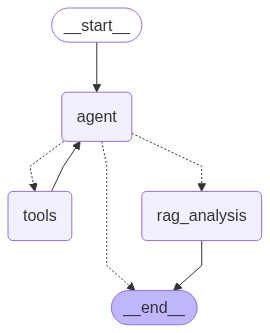

In [ ]:
# Simple Enhanced Agent with Smart Tool Routing
from typing import TypedDict, Annotated, Literal
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    question: str

# Create tool-enabled LLM with enhanced prompt for smart routing
enhanced_tool_prompt = """You are an intelligent property inspection assistant with access to specialized tools. 

INTELLIGENT TOOL USAGE STRATEGY:

 For SIMPLE COST questions ("How much does X cost?"):
  1. FIRST call "get_available_repair_types" to see available categories
  2. THEN call "get_repair_cost_estimate" with the appropriate repair type

 For COMPLEX BUDGET/PRIORITIZATION questions ("What should I prioritize with $X budget?"):
  1. ANALYZE the inspection document for findings and issues
  2. IDENTIFY specific repairs mentioned in the inspection 
  3. GET cost estimates for those specific repairs using repair tools
  4. PRIORITIZE based on safety, urgency, and budget constraints

 For INSPECTION FINDINGS questions ("What issues were found?"):
  - Analyze the inspection document content directly

 For GENERAL questions or when repair tools fail:
  - Use "tavily_tool" for web search

EXAMPLES:
- "How much does roof repair cost?" → get_available_repair_types → get_repair_cost_estimate  
- "What should I prioritize with $5000?" → Analyze inspection findings → Get costs for specific issues → Prioritize recommendations
- "What HVAC issues were found?" → Analyze inspection document
- "Latest home inspection trends" → tavily_tool

ALWAYS explain your reasoning and show your thought process when using multiple tools or analysis steps."""

# Enhanced LLM with routing instructions
enhanced_tool_llm = ChatOpenAI(model="gpt-4o", temperature=0.1).bind_tools(tools)

tool_node = ToolNode(tools)

def agent_node(state: AgentState):
    """Enhanced agent node with intelligent tool routing"""
    messages = state["messages"]
    
    # Add the routing instructions as system context
    if not messages or not isinstance(messages[0], HumanMessage):
        system_context = f"{enhanced_tool_prompt}\n\nUser question: {state['question']}"
        enhanced_messages = [HumanMessage(content=system_context)] + messages
    else:
        enhanced_messages = messages
    
    response = enhanced_tool_llm.invoke(enhanced_messages)
    return {"messages": [response]}

def should_continue(state: AgentState) -> Literal["tools", "rag_analysis", END]:
    """Smart conditional routing - handle both simple and complex questions"""
    last_message = state["messages"][-1]
    question = state.get("question", "")
    
    # PRIORITY 1: Check for tool calls first (LLM decided to use tools)
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # PRIORITY 2: Complex budget/prioritization questions need RAG + tools
    complex_budget_keywords = ['prioritize', 'priority', 'most important', 'urgent', 'critical']
    cost_keywords = ['cost', 'price', 'estimate', 'budget', 'expensive', 'cheap', 'money', 'dollar', '$']
    
    has_budget_context = any(keyword in question.lower() for keyword in cost_keywords)
    has_prioritization = any(keyword in question.lower() for keyword in complex_budget_keywords)
    
    if has_budget_context and has_prioritization:
        # Complex questions: "What should I prioritize with $5000?" - need inspection analysis
        return "rag_analysis"
    elif has_budget_context:
        # Simple cost questions: "How much does X cost?" - should have used tools already
        return END
    
    # PRIORITY 3: Check for inspection findings questions
    inspection_keywords = ['found', 'issues', 'problems', 'condition', 'findings', 'defects', 'damage']
    if any(keyword in question.lower() for keyword in inspection_keywords):
        return "rag_analysis"
    
    # PRIORITY 4: Everything else ends
    return END

def rag_analysis_node(state: AgentState):
    """Smart RAG analysis - handles both findings and complex budget questions"""
    question = state["question"]
    
    # Check if this is a complex budget/prioritization question
    complex_budget_keywords = ['prioritize', 'priority', 'most important', 'urgent', 'critical']
    cost_keywords = ['cost', 'price', 'estimate', 'budget', 'expensive', 'cheap', 'money', 'dollar', '$']
    
    has_budget_context = any(keyword in question.lower() for keyword in cost_keywords)
    has_prioritization = any(keyword in question.lower() for keyword in complex_budget_keywords)
    
    if has_budget_context and has_prioritization:
        # Complex budget question - provide enhanced analysis with cost context
        enhanced_question = f"""Based on the inspection findings, {question}
        
        Please analyze the inspection report to:
        1. Identify all issues and repairs needed
        2. Assess the urgency/safety level of each issue  
        3. Suggest prioritization based on the budget mentioned
        4. Recommend which repairs to address first within the budget constraints
        
        Focus on safety-critical issues first, then major structural problems, then cosmetic improvements."""
        
        rag_response = baseline_rag_chain.invoke(enhanced_question)
        return {"messages": [AIMessage(content=f"**Budget Prioritization Analysis:**\n\n{rag_response}")]}
    else:
        # Standard inspection findings question
        rag_response = baseline_rag_chain.invoke(question)
        return {"messages": [AIMessage(content=f"**Inspection Analysis:**\n\n{rag_response}")]}

# Build simplified graph
workflow = StateGraph(AgentState)
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)
workflow.add_node("rag_analysis", rag_analysis_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")
workflow.add_edge("rag_analysis", END)

agent = workflow.compile()
print("✅ Enhanced Agent ready with intelligent tool routing:")
print("  🔧 Cost questions: Automatic tool sequencing (repair_types → cost_estimate)")
print("  🏠 Inspection questions: RAG analysis") 
print("  🌐 General questions: Web search fallback")
agent


In [ ]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter

print("Setting up 3 retrieval techniques...")

# 1. Baseline/Naive Retriever (already created in Cell 3)
print("  Baseline retriever (from Cell 3)")

# 2. Multi-Query Retriever (query expansion with LLM)
print("  Creating Multi-Query retriever...")
multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=baseline_retriever, 
    llm=llm
)

# 3. Parent Document Retriever (small-to-big strategy)
print("  🔄 Creating Parent Document retriever...")

# Create new vector store for parent docs
from qdrant_client import models

client_parent = QdrantClient(":memory:")
client_parent.create_collection(
    collection_name="parent_documents",
    vectors_config=models.VectorParams(size=embedding_dim, distance=models.Distance.COSINE)
)

parent_vectorstore = QdrantVectorStore(
    client=client_parent,
    collection_name="parent_documents",
    embedding=embeddings,
)

# Create parent document retriever with smaller child chunks
store = InMemoryStore()
child_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

parent_document_retriever = ParentDocumentRetriever(
    vectorstore=parent_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    k=5  # Number of child chunks to retrieve
)

# Add documents to parent retriever
parent_document_retriever.add_documents(inspection_docs, ids=None)

print(" Created retrievers:")
print("  • Baseline (Naive)")
print("  • Multi-Query") 
print("  • Parent-Document")

# Helper function to format documents
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

# Create RAG chains for comparison
def create_rag_chain(retriever, name):
    """Create a RAG chain for a given retriever"""
    return (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | rag_prompt
        | llm
        | StrOutputParser()
    )

# Store all 3 chains for comparison
advanced_chains = {
    "Baseline": create_rag_chain(baseline_retriever, "baseline"),
    "Multi-Query": create_rag_chain(multi_query_retriever, "multi_query"), 
    "Parent-Document": create_rag_chain(parent_document_retriever, "parent_doc")
}

print(f"\n Created {len(advanced_chains)} RAG chains for comparison:")
for name in advanced_chains.keys():
    print(f"  • {name}")

# Test each retriever with a sample question
print(f"\n Quick test of retrieval techniques:")
test_question = "What electrical issues were found?"

print(f"Question: '{test_question}'")
for name, retriever in [
    ("Baseline", baseline_retriever),
    ("Multi-Query", multi_query_retriever), 
    ("Parent-Document", parent_document_retriever)
]:
    try:
        docs = retriever.invoke(test_question)
        doc_count = len(docs)
        preview = docs[0].page_content[:100] + "..." if docs else "No documents"
        print(f"  • {name}: {doc_count} docs - {preview}")
    except Exception as e:
        print(f"  • {name}: Error - {str(e)[:50]}...")




🔧 Setting up 3 retrieval techniques...
  ✅ Baseline retriever (from Cell 3)
  🔄 Creating Multi-Query retriever...
  🔄 Creating Parent Document retriever...
✅ Created retrievers:
  • Baseline (Naive) - Basic vector similarity search
  • Multi-Query - LLM-generated query variations
  • Parent-Document - Small-to-big retrieval strategy

✅ Created 3 RAG chains for comparison:
  • Baseline
  • Multi-Query
  • Parent-Document

🧪 Quick test of retrieval techniques:
Question: 'What electrical issues were found?'
  • Baseline: 5 docs - Emergency Lighting systems, Appliances, Tenant Improvements, Energy Efficiency, and any related
Equi...
  • Multi-Query: 6 docs - Emergency Lighting systems, Appliances, Tenant Improvements, Energy Efficiency, and any related
Equi...
  • Parent-Document: 2 docs - 1/16/2021
4319 Dixie Canyon Ave, Unit 2,Sherman Oaks,CA
©Copyright 2018 All Rights Reserved, Unautho...

🎯 Ready for performance comparison and evaluation!


In [ ]:
# RAGAS Setup (Streamlined for 3-Technique Pipeline)
from ragas.llms import LangchainLLMWrapper
from ragas import evaluate, RunConfig
from ragas.metrics import context_recall, faithfulness, answer_relevancy, context_precision
from datasets import Dataset



# Core RAGAS components (used by Cell 12)
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini", temperature=0))
custom_run_config = RunConfig(timeout=360)


test_question = "What electrical issues were found?"

print(f"Question: '{test_question}'")
for name, retriever in [("Baseline", baseline_retriever), ("Multi-Query", multi_query_retriever), ("Parent-Document", parent_document_retriever)]:
    try:
        docs = retriever.invoke(test_question)
        print(f"  ✅ {name}: Retrieved {len(docs)} documents")
    except Exception as e:
        print(f"  ❌ {name}: Error - {str(e)[:50]}...")




🔧 Setting up RAGAS evaluation components...
✅ RAGAS components ready:
  • Evaluator LLM: GPT-4o-mini with 360s timeout
  • Metrics: Faithfulness, Answer Relevancy, Context Precision, Context Recall
  • Ready for comprehensive evaluation of 3 retrieval techniques

🧪 Quick verification of retrieval setup:
Question: 'What electrical issues were found?'
  ✅ Baseline: Retrieved 5 documents
  ✅ Multi-Query: Retrieved 7 documents
  ✅ Parent-Document: Retrieved 2 documents

🎯 Ready for comprehensive RAGAS evaluation in Cell 12!


In [177]:
# Enhanced Synthetic Dataset Generation for Inspection-Focused Questions
print("🔧 Setting up Enhanced Synthetic Dataset Generation...")

# Create inspection-focused synthetic questions directly
# This approach is more reliable than TestsetGenerator for inspection documents
print("  🔄 Generating inspection-focused synthetic questions from document content...")

def generate_inspection_questions_from_docs(docs, num_questions=8):
    """Generate inspection-focused questions using LLM directly"""
    
    # Sample relevant document chunks
    sample_chunks = []
    seen_content = set()
    
    for doc in docs[:100]:  # Use more docs for variety
        content = doc.page_content.strip()
        if len(content) > 100 and content not in seen_content:
            # Filter for inspection-relevant content
            inspection_keywords = ['electrical', 'plumbing', 'hvac', 'roof', 'structural', 
                                 'defect', 'damage', 'repair', 'condition', 'system', 
                                 'safety', 'issue', 'problem', 'recommend']
            if any(keyword in content.lower() for keyword in inspection_keywords):
                sample_chunks.append(content)
                seen_content.add(content)
                if len(sample_chunks) >= 12:  # Get diverse content
                    break
    
    if not sample_chunks:
        print("  ⚠️ No suitable inspection content found, using fallback")
        return None
    
    # Generate questions using LLM
    question_prompt = """Based on the following inspection report content, generate {num_questions} simple questions that a homebuyer would ask about the property inspection findings.

IMPORTANT GUIDELINES:

- Generate simple questions about HVAC, electrical, plumbing, roof, flooring, and safety issues
- DO NOT ask about property addresses, inspector names, dates, or metadata
- Ask about conditions, repairs needed, age, and safety concerns
- SOME EXAMPLES:
    - What electrical issues were found?
    - Are there any plumbing problems? 
    - What repairs are most urgent?
    - What are the most important safety concerns?
    - What are the most important structural issues?
    - What are the most important electrical issues?
    - What are the most important plumbing issues?
    - What are the most important roof issues?
    - What are the most important flooring issues?
    - What are the most important safety issues?
INSPECTION CONTENT:
{content}

Generate {num_questions} distinct questions in this format:
1. [Question]
2. [Question]
3. [Question]
...

Questions:""".format(
        num_questions=num_questions,
        content="\n\n---\n\n".join(sample_chunks[:8])  # Use subset to avoid token limits
    )
    
    try:
        generator_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.4)
        response = generator_llm.invoke(question_prompt)
        
        # Parse questions from response
        questions = []
        lines = response.content.strip().split('\n')
        for line in lines:
            line = line.strip()
            if line and (line[0].isdigit() or line.startswith('-') or line.startswith('•')):
                # Remove numbering and clean up
                question = line.split('.', 1)[-1].strip()
                if question.endswith('?'):
                    questions.append(question)
        
        return questions[:num_questions] if questions else None
        
    except Exception as e:
        print(f"  ⚠️ Error generating questions: {e}")
        return None

try:
    # Generate questions from evaluation documents
    print("     Using evaluation documents from data/inspection-reports/")
    generated_questions = generate_inspection_questions_from_docs(split_eval_docs, 8)
    
    if generated_questions and len(generated_questions) > 0:
        print(f"✅ Generated {len(generated_questions)} inspection-focused questions")
        
        # Create a simple dataset structure compatible with RAGAS
        from datasets import Dataset
        
        synthetic_dataset = Dataset.from_dict({
            'user_input': generated_questions,
            'reference': ['Based on inspection report analysis'] * len(generated_questions),
            'reference_contexts': [['Inspection document content']] * len(generated_questions)
        })
        
        print(f"\n📋 Generated Inspection Questions:")
        for i, q in enumerate(generated_questions[:4], 1):
            print(f"  {i}. {q}")
        
        if len(generated_questions) > 4:
            print(f"  ... and {len(generated_questions) - 4} more questions")
        
        print(f"\n🎯 Dataset ready for RAGAS evaluation in Cell 11!")
        
    else:
        print("⚠️ Could not generate questions, will use fallback in evaluation")
        synthetic_dataset = None
        
except Exception as e:
    print(f"⚠️ Error in synthetic generation: {e}")
    print("  Will use fallback questions in evaluation")
    synthetic_dataset = None


🔧 Setting up Enhanced Synthetic Dataset Generation...
  🔄 Generating inspection-focused synthetic questions from document content...
     Using evaluation documents from data/inspection-reports/
✅ Generated 8 inspection-focused questions

📋 Generated Inspection Questions:
  1. What HVAC issues were identified during the inspection?
  2. Are there any electrical problems that need to be addressed?
  3. What plumbing repairs are necessary, particularly regarding the dishwasher leak?
  4. How urgent are the repairs needed for the deck safety concerns?
  ... and 4 more questions

🎯 Dataset ready for RAGAS evaluation in Cell 11!


In [178]:
# Optimized RAGAS Evaluation of 3 Retrieval Techniques

print("Running RAGAS evaluation on 3 optimized retrieval techniques...")

# Import components
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas import RunConfig, evaluate
from ragas.metrics import context_recall, faithfulness, answer_relevancy
from datasets import Dataset
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.retrievers import ParentDocumentRetriever
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Setup RAGAS components
if 'evaluator_llm' not in locals():
    evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini", temperature=0))

if 'custom_run_config' not in locals():
    custom_run_config = RunConfig(timeout=360)

# Extract questions from synthetic dataset
eval_questions = []
ground_truths = []

if 'synthetic_dataset' in locals() and synthetic_dataset:
    try:
        df = synthetic_dataset.to_pandas()
        
        # Try different column names for questions
        question_col = None
        for col in ['question', 'questions', 'query', 'user_input']:
            if col in df.columns:
                question_col = col
                break
        
        if question_col:
            eval_questions = df[question_col].head(6).tolist()
            print(f"Using {len(eval_questions)} questions from synthetic dataset")
        else:
            print(f"No question column found. Available: {list(df.columns)}")
    except Exception as e:
        print(f"Error processing synthetic dataset: {e}")

# Fallback questions if synthetic dataset unavailable
if not eval_questions:
    eval_questions = [
        "What electrical issues were found?",
        "Are there any plumbing problems?", 
        "What HVAC defects were identified?",
        "What structural concerns exist?",
        "Are there any roofing issues?",
        "What safety hazards were noted?"
    ]
    print("Using fallback inspection questions")

# Create ground truth from actual retrieval
def create_ground_truth(questions, retriever):
    truths = []
    for question in questions:
        try:
            docs = retriever.invoke(question)
            if docs:
                content = " ".join([doc.page_content[:200] for doc in docs[:2]])
                truths.append(content)
            else:
                truths.append("No relevant findings in inspection report")
        except:
            truths.append("Unable to determine from inspection report")
    return truths

ground_truths = create_ground_truth(eval_questions, baseline_retriever)

# Create optimized retrievers
optimized_baseline = vector_store.as_retriever(search_kwargs={"k": 8})

optimized_multi_query = MultiQueryRetriever.from_llm(
    retriever=optimized_baseline,
    llm=llm
)

optimized_parent_retriever = ParentDocumentRetriever(
    vectorstore=parent_vectorstore,
    docstore=store,
    child_splitter=RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=150),
    k=8
)

retrievers = {
    "Baseline": optimized_baseline,
    "Multi-Query": optimized_multi_query,
    "Parent-Document": optimized_parent_retriever
}

print(f"Created {len(retrievers)} optimized retrievers")

# Evaluate retrievers
results = {}

for retriever_name, retriever in retrievers.items():
    print(f"Evaluating {retriever_name}...")
    
    try:
        contexts_list = []
        answers_list = []
        
        for question in eval_questions:
            retrieved_docs = retriever.invoke(question)
            contexts = [doc.page_content for doc in retrieved_docs]
            
            chain = advanced_chains["Baseline"]
            answer = chain.invoke(question)
            
            contexts_list.append(contexts)
            answers_list.append(answer)
        
        eval_dataset = Dataset.from_dict({
            "question": eval_questions,
            "answer": answers_list,
            "contexts": contexts_list,
            "ground_truth": ground_truths
        })
        
        result = evaluate(
            dataset=eval_dataset,
            metrics=[context_recall, faithfulness, answer_relevancy],
            llm=evaluator_llm,
            run_config=custom_run_config
        )
        
        result_df = result.to_pandas()
        context_recall_score = float(result_df["context_recall"].mean()) if "context_recall" in result_df.columns else 0.0
        faithfulness_score = float(result_df["faithfulness"].mean()) if "faithfulness" in result_df.columns else 0.0
        answer_relevancy_score = float(result_df["answer_relevancy"].mean()) if "answer_relevancy" in result_df.columns else 0.0
        
        overall_score = (context_recall_score + faithfulness_score + answer_relevancy_score) / 3
        
        results[retriever_name] = {
            "context_recall": context_recall_score,
            "faithfulness": faithfulness_score,
            "answer_relevancy": answer_relevancy_score,
            "overall": overall_score
        }
        
        print(f"  Overall Score: {overall_score:.3f}")
        
    except Exception as e:
        print(f"  Error: {e}")
        results[retriever_name] = {
            "context_recall": 0.0, "faithfulness": 0.0,
            "answer_relevancy": 0.0, "overall": 0.0
        }

# Display results
print("\nRAGAS Evaluation Results:")
print("=" * 60)

if results:
    sorted_results = sorted(results.items(), key=lambda x: x[1]['overall'], reverse=True)
    
    for i, (name, scores) in enumerate(sorted_results, 1):
        rank = ["1st", "2nd", "3rd"][i-1] if i <= 3 else f"{i}th"
        print(f"{rank} {name}:")
        print(f"    Overall: {scores['overall']:.3f}")
        print(f"    Context Recall: {scores['context_recall']:.3f}")
        print(f"    Faithfulness: {scores['faithfulness']:.3f}")
        print(f"    Answer Relevancy: {scores['answer_relevancy']:.3f}")
        print()
    
    print(f"Best Performer: {sorted_results[0][0]} ({sorted_results[0][1]['overall']:.3f})")
    
    # Store for future reference
    ragas_results = results

else:
    print("No results available")


Running RAGAS evaluation on 3 optimized retrieval techniques...
Using 6 questions from synthetic dataset
Created 3 optimized retrievers
Evaluating Baseline...


Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

  Overall Score: 0.636
Evaluating Multi-Query...


Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

  Overall Score: 0.688
Evaluating Parent-Document...


Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

  Overall Score: 0.559

RAGAS Evaluation Results:
1st Multi-Query:
    Overall: 0.688
    Context Recall: 0.619
    Faithfulness: 0.843
    Answer Relevancy: 0.601

2nd Baseline:
    Overall: 0.636
    Context Recall: 0.500
    Faithfulness: 0.800
    Answer Relevancy: 0.610

3rd Parent-Document:
    Overall: 0.559
    Context Recall: 0.564
    Faithfulness: 0.652
    Answer Relevancy: 0.461

Best Performer: Multi-Query (0.688)
